# StarFast example notebook
This notebook was used to generate all of the images in DMTN-012 (https://github.com/lsst-dm/dmtn-012/blob/master/index.rst), and illustrates the basic uses of StarFast.

For these examples, I am using a reference image at close to zenith (airmass 1.00), and an "observed" image taken at airmass 1.2 for simple image differencing (with and without noise). I have not included any attempt at PSF matching, and so the dipoles for most objects are worse. However, this notebook is examining the effect of Differential Chromatic Refraction (DCR) and I want the effects to be unambiguous. Also, note that the dipoles may be in different directions between very hot and very cool stars! In some cases, standard PSF matching might make the dipoles of very hot and rare objects worse.

In the first section, I use star_sim to generate simulated images with 10,000 stars in the LSST u-band from a catalog of type K - type O stars randomly distributed within a conical volume 1000 light years long and ~4 arcmin wide.

In the second section, I simulate just a single star, but as each spectral type and at u and g bands. 


In [2]:
%matplotlib inline
import os
import cPickle
import galsim 
import lsst.afw.geom as afwGeom
from lsst.sims.photUtils import matchStar
import numpy as np
import time
from look import look
from StarFast import star_sim
from fast_dft import fast_dft

First, load in model Kurucz SEDs from sims.photUtils

In [3]:
pickle_file = 'sed_list.pickle'
if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as dumpfile:
        sed_list = cPickle.load(dumpfile)
else:
    %%capture
    matchStarObj = matchStar()
    sed_list = matchStarObj.loadKuruczSEDs()
    with open(pickle_file, 'wb') as dumpfile:
        cPickle.dump(sed_list, dumpfile, cPickle.HIGHEST_PROTOCOL)

Set up the basic parameters that each simulation will use

In [11]:
seed = 5
dimension = 1024 # number of pixels on a side of the simulation
pad_image = 1.5 # 
n_star = 10000
pixel_scale = 0.25 # arcsec / pixel
band_name = 'u'  # vaild options are 'u', 'g', 'r', 'i', 'z', or 'y'
hottest_star='O' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='K' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star
wavelength_step = 3 # wavelength bin size, in nm
photons_per_adu = 1e4
gsp = galsim.GSParams(folding_threshold=1.0/(dimension), maximum_fft_size=12288)
psf = galsim.Kolmogorov(fwhm=1.0, flux=1, gsparams=gsp)

ref_elevation = 85.0 # in degrees
ref_azimuth = 0.0 # in degrees

obs_elevation = 90.0 - 33.6 # in degrees
obs_azimuth = 20.0 # in degrees

## StarFast simulation without noise

In [12]:
sky_noise = 0.0
instrument_noise = 0.0
photon_noise = False
timing_ref = -time.time()
ref_image=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,
                    instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=False,
                    elevation=ref_elevation, azimuth=ref_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                    hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)
timing_ref += time.time()
print("Total time to generate reference image: ", timing_ref)
timing_obs = -time.time()
obs_image=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,
                     instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=True,
                     elevation=obs_elevation, azimuth=obs_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                     hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)
timing_obs +=  time.time()
print("Total time to generate observed image: ", timing_obs)

Number and flux contribution of stars of each type:
 [K 5124| 0.30%] [G 3303| 0.58%] [F 1255| 0.85%] [A 274| 2.23%] [B 44| 96.04%] [O 0| 0.00%]
Time to model 9963 stars: [22.010s | 0.00221s per star]
FFT timing (single plane): [0.289s]
Time to model 37 bright stars: [0.348s | 0.00941s per star]
FFT timing (single plane): [1.279s]
('Total time to generate reference image: ', 37.736541986465454)
Number and flux contribution of stars of each type:
 [K 5124| 0.30%] [G 3303| 0.58%] [F 1255| 0.85%] [A 274| 2.23%] [B 44| 96.04%] [O 0| 0.00%]
Time to model 9963 stars: [71.803s | 0.00721s per star]
FFT timing for 23 DCR planes: [7.741s | 0.337s per plane]
Time to model 37 bright stars: [8.650s | 0.23380s per star]
FFT timing for 23 DCR planes: [31.638s | 1.376s per plane]
('Total time to generate observed image: ', 131.5635631084442)


## StarFast simulation with added noise

In [17]:
sky_noise = 0.001
instrument_noise = 0.001
photon_noise = False
timing_ref = -time.time()
ref_image_addnoise=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,
                    instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=False,
                    elevation=ref_elevation, azimuth=ref_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                    hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)

timing_ref += time.time()
print("Total time to generate reference image: ", timing_ref)
timing_obs = -time.time()
obs_image_addnoise=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,
                     instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=True,
                     elevation=obs_elevation, azimuth=obs_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                     hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)
timing_obs +=  time.time()
print("Total time to generate observed image: ", timing_obs)

Number and flux contribution of stars of each type:
 [K 5124| 0.30%] [G 3303| 0.58%] [F 1255| 0.85%] [A 274| 2.23%] [B 44| 96.04%] [O 0| 0.00%]
Time to model 9963 stars: [23.987s | 0.00241s per star]
FFT timing (single plane): [0.301s]
Time to model 37 bright stars: [0.356s | 0.00961s per star]
FFT timing (single plane): [1.245s]
('Total time to generate reference image: ', 38.67668008804321)
Number and flux contribution of stars of each type:
 [K 5124| 0.30%] [G 3303| 0.58%] [F 1255| 0.85%] [A 274| 2.23%] [B 44| 96.04%] [O 0| 0.00%]
Time to model 9963 stars: [78.880s | 0.00792s per star]
FFT timing for 23 DCR planes: [11.233s | 0.488s per plane]
Time to model 37 bright stars: [9.696s | 0.26204s per star]
FFT timing for 23 DCR planes: [33.898s | 1.474s per plane]
('Total time to generate observed image: ', 145.97874999046326)


## Make a few comparison plots

In [7]:
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.cm as cm

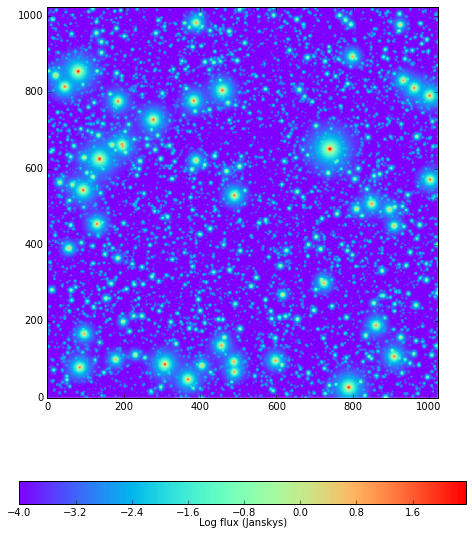

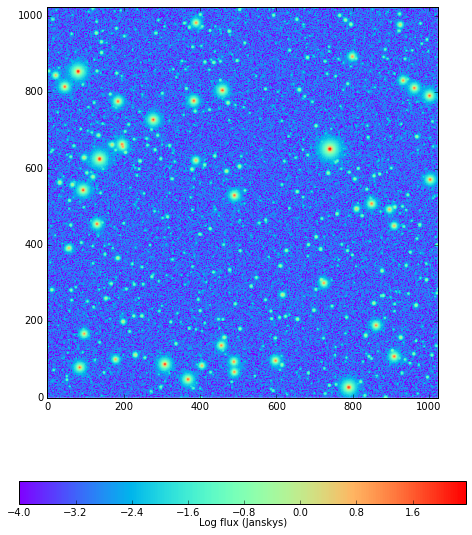

In [18]:
fig = plt.figure(figsize=(10, 10), dpi=300)
fig_show = plt.imshow(np.clip(np.log10(np.abs(ref_image)),-4, np.Inf), interpolation='none', origin='lower', cmap=cm.rainbow)
cbar=plt.colorbar(fig_show, orientation='horizontal', shrink=.8)
cbar.set_label('Log flux (Janskys)', labelpad=0, rotation=0)
# plt.savefig('ref_img10000_log.png',bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(10, 10), dpi=300)
fig_show = plt.imshow(np.clip(np.log10(np.abs(ref_image_addnoise)),-4, np.Inf), interpolation='none', origin='lower', cmap=cm.rainbow)
cbar=plt.colorbar(fig_show, orientation='horizontal', shrink=.8)
cbar.set_label('Log flux (Janskys)', labelpad=0, rotation=0)
# plt.savefig('ref_img10000_log_addnoise.png',bbox_inches='tight', dpi=300)

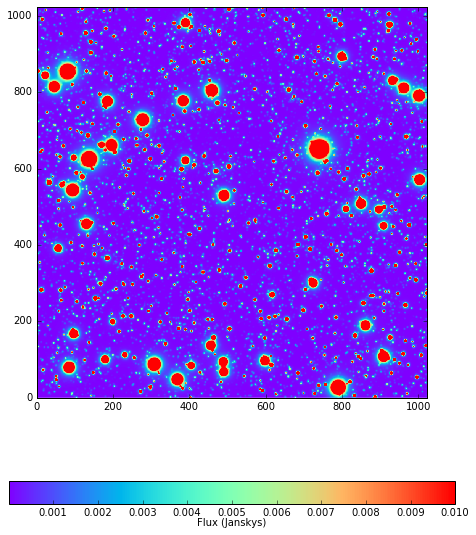

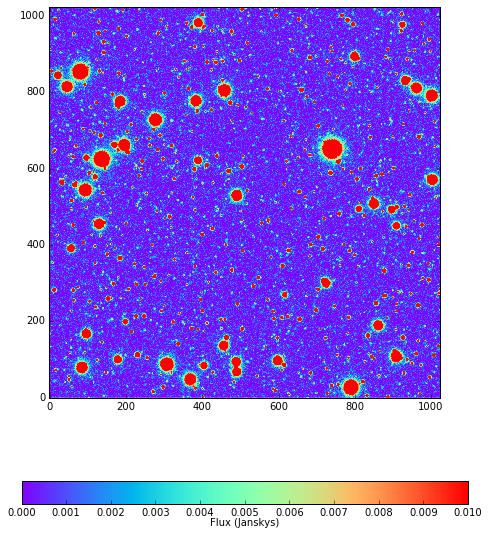

In [19]:
fig = plt.figure(figsize=(10,10), dpi=300)
fig_show = plt.imshow(np.clip(ref_image,0,0.01), interpolation='none', origin='lower', cmap=cm.rainbow)
cbar=plt.colorbar(fig_show, orientation='horizontal', shrink=.8)
cbar.set_label('Flux (Janskys)', labelpad=0, rotation=0)
# plt.savefig('ref_img10000_linear.png',bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(10,10), dpi=300)
fig_show = plt.imshow(np.clip(ref_image_addnoise,0,0.01), interpolation='none', origin='lower', cmap=cm.rainbow)
cbar=plt.colorbar(fig_show, orientation='horizontal', shrink=.8)
cbar.set_label('Flux (Janskys)', labelpad=0, rotation=0)
# plt.savefig('ref_img10000_linear_addnoise.png',bbox_inches='tight', dpi=300)

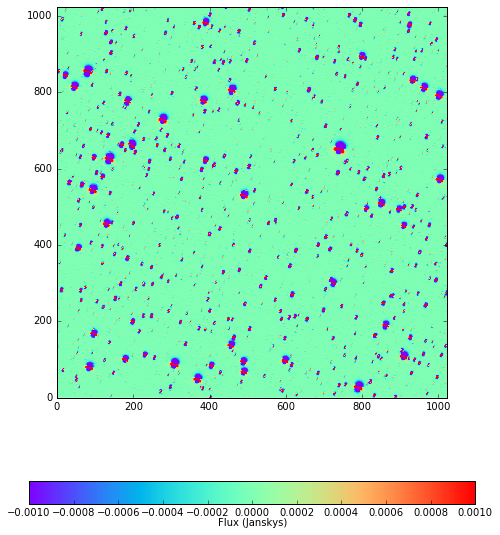

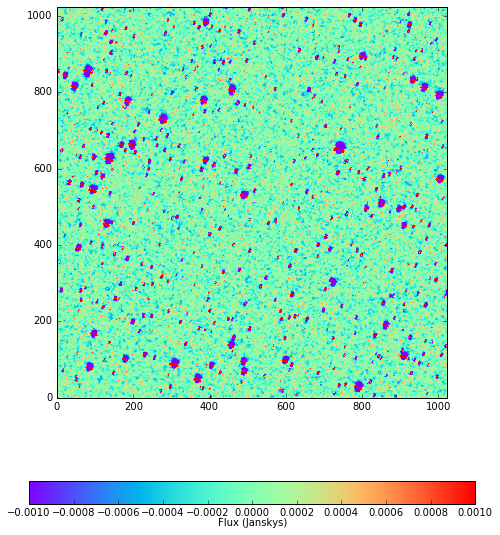

In [20]:
fig = plt.figure(figsize=(10,10), dpi=300)
dcr_color_scale=1e-3
fig_show = plt.imshow(np.clip(ref_image-obs_image,-dcr_color_scale, dcr_color_scale), interpolation='none', origin='lower', cmap=cm.rainbow)
cbar=plt.colorbar(fig_show, orientation='horizontal', shrink=.8)
cbar.set_label('Flux (Janskys)', labelpad=0, rotation=0)
# plt.savefig('dcr_img10000_linear.png',bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(10,10), dpi=300)
fig_show = plt.imshow(np.clip(ref_image_addnoise-obs_image_addnoise,-dcr_color_scale, dcr_color_scale), interpolation='none', origin='lower', cmap=cm.rainbow)
cbar=plt.colorbar(fig_show, orientation='horizontal', shrink=.8)
cbar.set_label('Flux (Janskys)', labelpad=0, rotation=0)
# plt.savefig('dcr_img10000_linear_addnoise.png',bbox_inches='tight', dpi=300)

# Explore the effect of DCR on single stars

In [11]:
dimension = 64 # number of pixels on a side of the simulation
pad_image = 1.5 # 
sky_noise = 0.0
instrument_noise = 0.0
photon_noise = False
n_star = 1
verbose = False

## u band

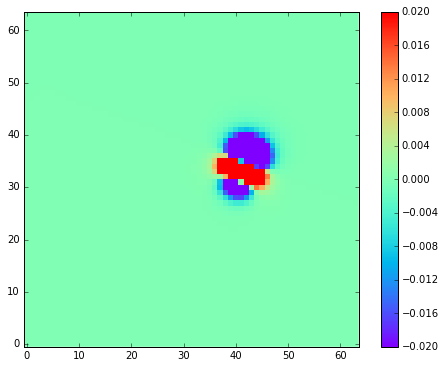

In [13]:
band_name = 'u'  # vaild options are 'u', 'g', 'r', 'i', 'z', or 'y'
hottest_star='O' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='O' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

ref_image_u_O=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                    instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=False,
                    elevation=ref_elevation, azimuth=ref_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                    hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)

obs_image_u_O=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                     instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=True,
                     elevation=obs_elevation, azimuth=obs_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                     hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)
look(ref_image_u_O - obs_image_u_O, range=[-0.02, 0.02])

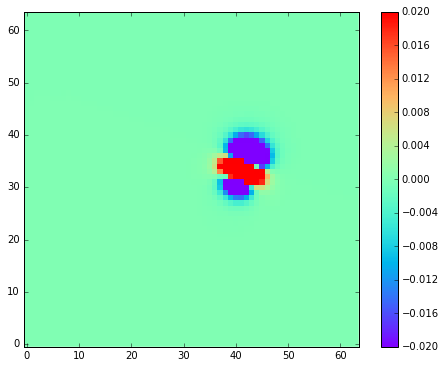

In [14]:
band_name = 'u'  # vaild options are 'u', 'g', 'r', 'i', 'z', or 'y'
hottest_star='B' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='B' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

ref_image_u_B=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                    instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=False,
                    elevation=ref_elevation, azimuth=ref_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                    hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)

obs_image_u_B=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                     instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=True,
                     elevation=obs_elevation, azimuth=obs_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                     hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)
look(ref_image_u_B - obs_image_u_B, range=[-0.02, 0.02])

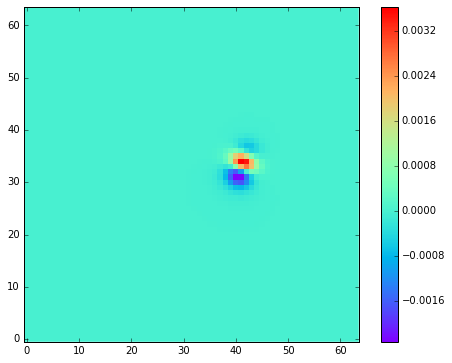

In [15]:
band_name = 'u'  # vaild options are 'u', 'g', 'r', 'i', 'z', or 'y'
hottest_star='A' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='A' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

ref_image_u_A=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                    instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=False,
                    elevation=ref_elevation, azimuth=ref_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                    hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)

obs_image_u_A=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                     instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=True,
                     elevation=obs_elevation, azimuth=obs_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                     hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)
look(ref_image_u_A - obs_image_u_A, range=[-0.02, 0.02])

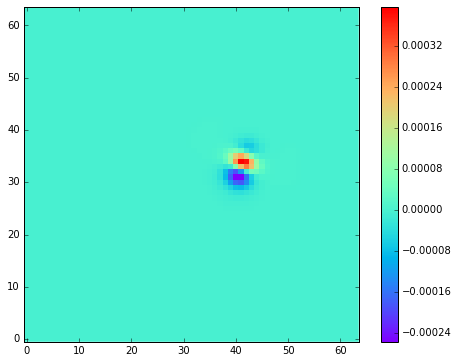

In [16]:
band_name = 'u'  # vaild options are 'u', 'g', 'r', 'i', 'z', or 'y'
hottest_star='F' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='F' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

ref_image_u_F=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                    instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=False,
                    elevation=ref_elevation, azimuth=ref_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                    hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)

obs_image_u_F=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                     instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=True,
                     elevation=obs_elevation, azimuth=obs_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                     hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)
look(ref_image_u_F - obs_image_u_F, range=[-0.02, 0.02])

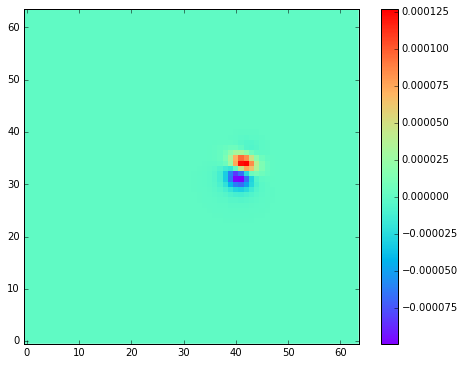

In [17]:
band_name = 'u'  # vaild options are 'u', 'g', 'r', 'i', 'z', or 'y'
hottest_star='G' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='G' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

ref_image_u_G=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                    instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=False,
                    elevation=ref_elevation, azimuth=ref_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                    hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)

obs_image_u_G=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                     instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=True,
                     elevation=obs_elevation, azimuth=obs_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                     hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)
look(ref_image_u_G - obs_image_u_G, range=[-0.02, 0.02])

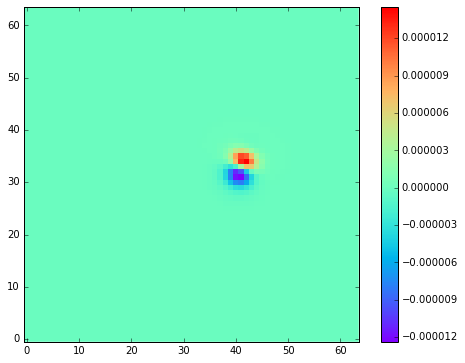

In [18]:
band_name = 'u'  # vaild options are 'u', 'g', 'r', 'i', 'z', or 'y'
hottest_star='K' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='K' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

ref_image_u_K=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                    instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=False,
                    elevation=ref_elevation, azimuth=ref_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                    hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)

obs_image_u_K=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                     instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=True,
                     elevation=obs_elevation, azimuth=obs_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                     hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)
look(ref_image_u_K - obs_image_u_K, range=[-0.02, 0.02])

# g band

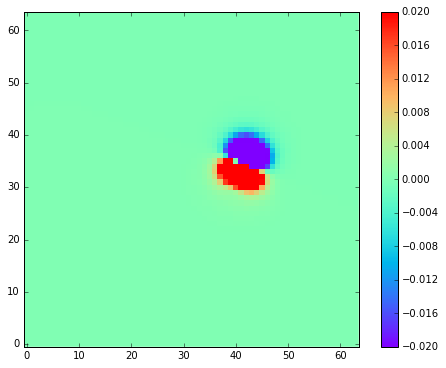

In [19]:
band_name = 'g'  # vaild options are 'u', 'g', 'r', 'i', 'z', or 'y'
hottest_star='O' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='O' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

ref_image_g_O=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                    instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=False,
                    elevation=ref_elevation, azimuth=ref_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                    hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)

obs_image_g_O=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                     instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=True,
                     elevation=obs_elevation, azimuth=obs_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                     hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)
look(ref_image_g_O - obs_image_g_O, range=[-0.02, 0.02])

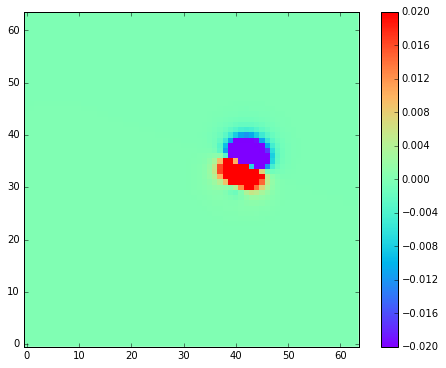

In [20]:
band_name = 'g'  # vaild options are 'u', 'g', 'r', 'i', 'z', or 'y'
hottest_star='B' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='B' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

ref_image_g_B=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                    instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=False,
                    elevation=ref_elevation, azimuth=ref_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                    hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)

obs_image_g_B=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                     instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=True,
                     elevation=obs_elevation, azimuth=obs_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                     hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)
look(ref_image_g_B - obs_image_g_B, range=[-0.02, 0.02])

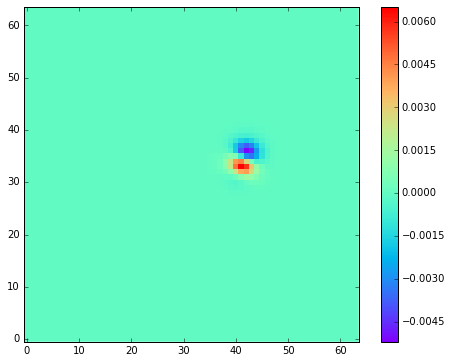

In [21]:
band_name = 'g'  # vaild options are 'u', 'g', 'r', 'i', 'z', or 'y'
hottest_star='A' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='A' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

ref_image_g_A=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                    instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=False,
                    elevation=ref_elevation, azimuth=ref_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                    hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)

obs_image_g_A=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                     instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=True,
                     elevation=obs_elevation, azimuth=obs_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                     hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)
look(ref_image_g_A - obs_image_g_A, range=[-0.02, 0.02])

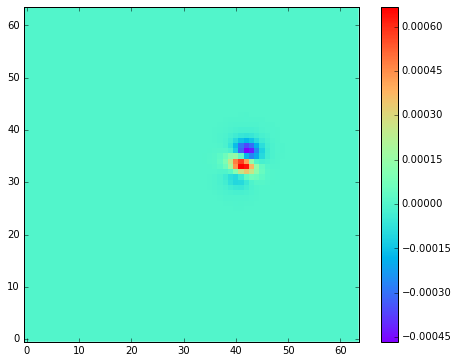

In [22]:
band_name = 'g'  # vaild options are 'u', 'g', 'r', 'i', 'z', or 'y'
hottest_star='F' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='F' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

ref_image_g_F=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                    instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=False,
                    elevation=ref_elevation, azimuth=ref_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                    hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)

obs_image_g_F=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                     instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=True,
                     elevation=obs_elevation, azimuth=obs_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                     hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)
look(ref_image_g_F - obs_image_g_F, range=[-0.02, 0.02])

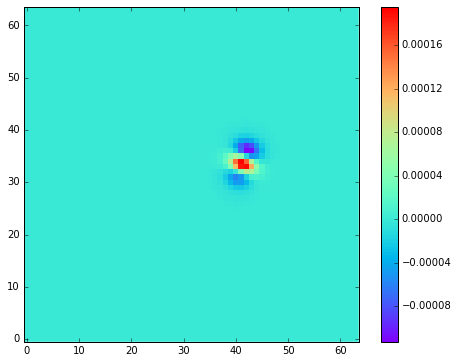

In [23]:
band_name = 'g'  # vaild options are 'u', 'g', 'r', 'i', 'z', or 'y'
hottest_star='G' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='G' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

ref_image_g_G=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                    instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=False,
                    elevation=ref_elevation, azimuth=ref_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                    hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)

obs_image_g_G=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                     instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=True,
                     elevation=obs_elevation, azimuth=obs_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                     hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)
look(ref_image_g_G - obs_image_g_G, range=[-0.02, 0.02])

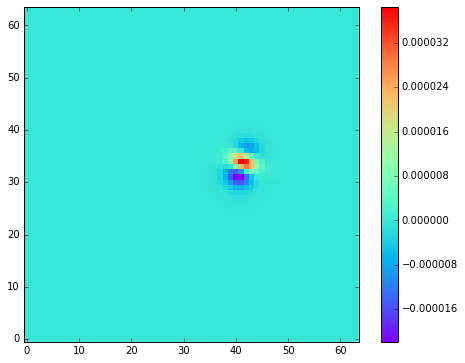

In [24]:
band_name = 'g'  # vaild options are 'u', 'g', 'r', 'i', 'z', or 'y'
hottest_star='K' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='K' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

ref_image_g_K=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                    instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=False,
                    elevation=ref_elevation, azimuth=ref_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                    hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)

obs_image_g_K=star_sim(seed=seed, psf=psf,n_star=n_star, x_size=dimension, y_size=dimension,
                    sky_noise=sky_noise, photon_noise=photon_noise,verbose=verbose,
                     instrument_noise=instrument_noise, pixel_scale=pixel_scale, dcr_flag=True,
                     elevation=obs_elevation, azimuth=obs_azimuth, band_name=band_name, wavelength_step=wavelength_step,
                     hottest_star=hottest_star, coolest_star=coolest_star,sed_list=sed_list, pad_image=pad_image)
look(ref_image_g_K - obs_image_g_K, range=[-0.02, 0.02])

# Comparison to GalSim